In [76]:
# imports
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
# constants
LOC_DATA = "./data"
CHAT_FILENAME = "/chat_{}.txt"

MEDIA = 'media_shared'
DELETED = 'deleted_message'
CELINE = 'Celine'
SAM = 'Sam'

emoji_pat = r'(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])'

what_eng = r'(\d+(?:/|-)\d+(?:/|-)\d+, \d+:\d+\d+ [A-Za-z\.]*) - (.*?): (.*)'
date_form1 = re.compile('(\d+/\d+/\d+, \d+:\d+\d+ [A-Z]*)')
date_form2 = re.compile('(\d+\-\d+-\d+, \d+:\d+\d+ [a-z\.]*)')

what_fr = r'(\d+.\d+.\d+ à \d+:\d+\d+ [a-z\.\’ ]*) - (.*?): (.*)'
what_pat = re.compile('(?:%s)|(?:%s)' % (what_eng, what_fr))
what_pat = what_eng

col_chat = ['timestamp',  'name', 'msg']
df_col = col_chat + ['time', 'date', 'msg_len']

print(what_pat)

(\d+(?:/|-)\d+(?:/|-)\d+, \d+:\d+\d+ [A-Za-z\.]*) - (.*?): (.*)


In [181]:
def to_df(msg):
    h = pd.DataFrame(msg, columns=col_chat)
    h['timestamp'] = h['timestamp'].str.upper()
    h['timestamp'] = h['timestamp'].str.replace('.', '')
    h['datetime'] = pd.to_datetime(h['timestamp'], format="%m/%d/%y, %I:%M %p", errors='coerce')
#     h['datetime'] = pd.to_datetime(h['timestamp'], errors='coerce')
    h.datetime.update(pd.to_datetime(h[h.datetime.isnull()].timestamp, errors='coerce', yearfirst=True))
    h['date'] = h['datetime'].dt.date
    h['time'] = h['datetime'].dt.time
    h['msg_len'] = h['msg'].str.replace('\n', '').str.len()
    h['name'] = h['name'].str.replace('Celine.*', CELINE)
    h['name'] = h['name'].str.replace('Sam.*', SAM)
    h['msg'] = h['msg'].replace('<Media omitted>', MEDIA)
    h['msg'] = h['msg'].replace('This message was deleted', DELETED)
    return h

def read_whatsapp(file_name):
    with open(filename, encoding='utf-8') as f:
        messages = re.findall(what_pat, f.read())
        f.close()
        
    return to_df(messages)

In [182]:
# read txt files
df = pd.DataFrame(columns=col_chat)
for i in range(4):
    filename = LOC_DATA + CHAT_FILENAME.format(i)
    print(filename)
    tmp = read_whatsapp(filename)
    print(tmp.count())
    df = pd.concat([df, tmp], axis=0, ignore_index=True, sort=True)
    
df.tail()

./data/chat_0.txt
timestamp    7808
name         7808
msg          7808
datetime     7808
date         7808
time         7808
msg_len      7808
dtype: int64
./data/chat_1.txt
timestamp    19781
name         19781
msg          19781
datetime     19781
date         19781
time         19781
msg_len      19781
dtype: int64
./data/chat_2.txt
timestamp    5
name         5
msg          5
datetime     5
date         5
time         5
msg_len      5
dtype: int64
./data/chat_3.txt
timestamp    35000
name         35000
msg          35000
datetime     35000
date         35000
time         35000
msg_len      35000
dtype: int64


,date,datetime,msg,msg_len,name,time,timestamp
62589,2020-09-25,2020-09-25 15:34:00,À demain,8.0,Sam,15:34:00,"2020-09-25, 3:34 PM"
62590,2020-09-25,2020-09-25 15:34:00,media_shared,15.0,Sam,15:34:00,"2020-09-25, 3:34 PM"
62591,2020-09-25,2020-09-25 15:34:00,Il n'est pas encore dans ma maison! XP,38.0,Celine,15:34:00,"2020-09-25, 3:34 PM"
62592,2020-09-25,2020-09-25 15:35:00,Aah,3.0,Sam,15:35:00,"2020-09-25, 3:35 PM"
62593,2020-09-25,2020-09-25 15:35:00,My bad 😂,8.0,Sam,15:35:00,"2020-09-25, 3:35 PM"


In [183]:
df[df.datetime.isnull()].head()

,date,datetime,msg,msg_len,name,time,timestamp


In [184]:
df[df.datetime.notnull()].head()

,date,datetime,msg,msg_len,name,time,timestamp
0,2018-09-26,2018-09-26 12:17:00,Heyo,4.0,Celine,12:17:00,"9/26/18, 12:17 PM"
1,2018-09-26,2018-09-26 12:18:00,l'Ornithorynque is where I'm going to eat,41.0,Sam,12:18:00,"9/26/18, 12:18 PM"
2,2018-09-26,2018-09-26 12:27:00,"Coming! There's so many ppl, so I'll pay later",46.0,Celine,12:27:00,"9/26/18, 12:27 PM"
3,2018-09-26,2018-09-26 21:40:00,http://aumc.epfl.ch/index.php/les-salles-de-mu...,64.0,Sam,21:40:00,"9/26/18, 9:40 PM"
4,2018-09-26,2018-09-26 21:40:00,This is the music association I was talking about,49.0,Sam,21:40:00,"9/26/18, 9:40 PM"


# Analysis
## Sam vs Celine

In [186]:
def agg_by_month(df):
    per = df.datetime.dt.to_period("M")
    new_df = df.groupby(
        [
            per,
            df['name']
        ]).agg({
        'msg': ['count'],
        'msg_len': ['sum', 'mean', 'median']
    }).reset_index()
    
    return new_df

# sam_agg = agg_by_month(df_sam)
# sam_agg.columns = ["_".join(x) for x in sam_agg.columns.ravel()]
df_agg = agg_by_month(df)
df_agg.head()

datetime    name   msg  msg_len                  
                   count      sum       mean median
0  2018-09  Celine     8    311.0  38.875000   32.0
1  2018-09     Sam    12    725.0  60.416667   54.0
2  2018-10  Celine   324  16440.0  50.740741   42.0
3  2018-10     Sam   396  20220.0  51.060606   42.0
4  2018-11  Celine  1082  58668.0  54.221811   46.0

Sam and Celine met in mid September. The first message was sent by Sam:
### "Heyo"
to let Celine know where he would be going to eat lunch, which Celine replied with:
### "Coming! There's so many ppl, so I'll pay later."
What she was going buy? Who knows?

Celine and Sam were on the same continent between Sept 2018 - Jan 2019, and started dating mid Dec 2018. The decline in messages in Jan 2019 can be explained by the fact that they were actually hanging out together, thus no messages were necessary.

On average, Sam sends more messages than Celine, and with more detail.

[Text(0,0,'2018-09'),
 Text(0,0,'2018-10'),
 Text(0,0,'2018-11'),
 Text(0,0,'2018-12'),
 Text(0,0,'2019-01'),
 Text(0,0,'2019-02'),
 Text(0,0,'2019-03'),
 Text(0,0,'2019-04'),
 Text(0,0,'2019-05'),
 Text(0,0,'2019-06'),
 Text(0,0,'2019-07'),
 Text(0,0,'2019-08'),
 Text(0,0,'2019-09'),
 Text(0,0,'2019-10'),
 Text(0,0,'2019-11'),
 Text(0,0,'2019-12'),
 Text(0,0,'2020-01'),
 Text(0,0,'2020-02'),
 Text(0,0,'2020-03'),
 Text(0,0,'2020-04'),
 Text(0,0,'2020-05'),
 Text(0,0,'2020-06'),
 Text(0,0,'2020-07'),
 Text(0,0,'2020-08'),
 Text(0,0,'2020-09')]

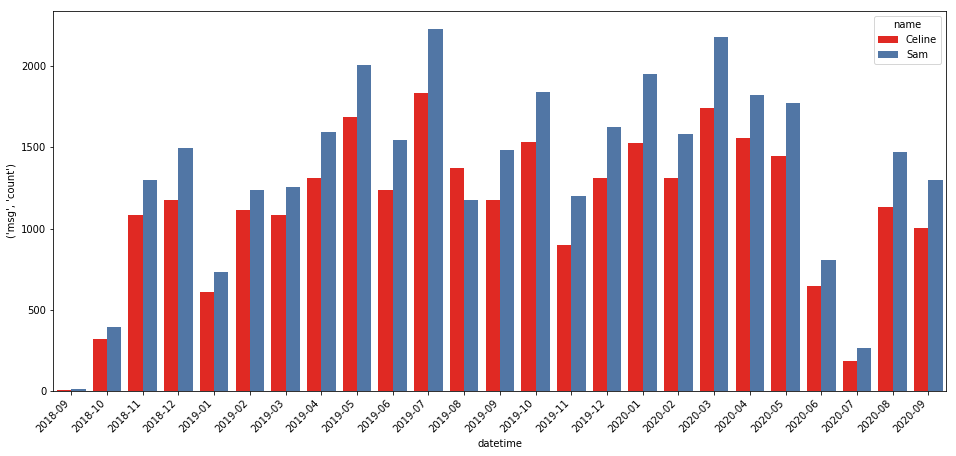

In [202]:
plt.figure(figsize=(16, 7))
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

bplot = sns.barplot(y=('msg', 'count'), hue='name', x='datetime', data=df_agg)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0,0,'2018-09'),
 Text(0,0,'2018-10'),
 Text(0,0,'2018-11'),
 Text(0,0,'2018-12'),
 Text(0,0,'2019-01'),
 Text(0,0,'2019-02'),
 Text(0,0,'2019-03'),
 Text(0,0,'2019-04'),
 Text(0,0,'2019-05'),
 Text(0,0,'2019-06'),
 Text(0,0,'2019-07'),
 Text(0,0,'2019-08'),
 Text(0,0,'2019-09'),
 Text(0,0,'2019-10'),
 Text(0,0,'2019-11'),
 Text(0,0,'2019-12'),
 Text(0,0,'2020-01'),
 Text(0,0,'2020-02'),
 Text(0,0,'2020-03'),
 Text(0,0,'2020-04'),
 Text(0,0,'2020-05'),
 Text(0,0,'2020-06'),
 Text(0,0,'2020-07'),
 Text(0,0,'2020-08'),
 Text(0,0,'2020-09')]

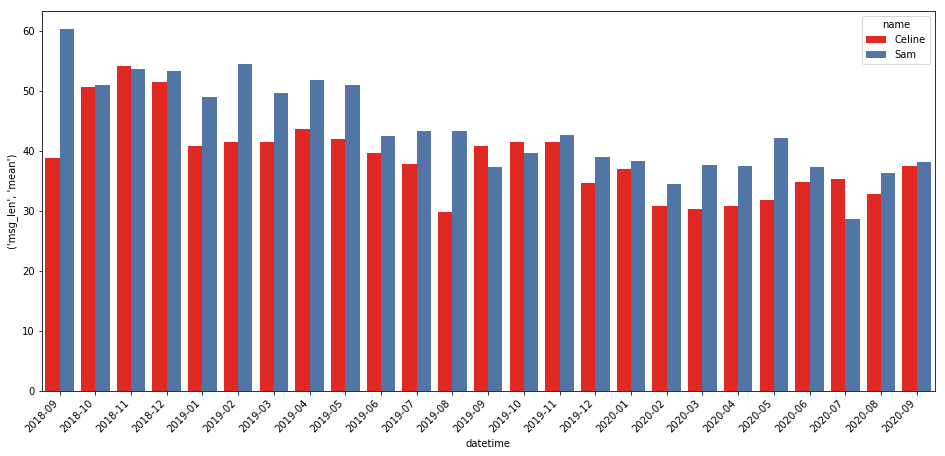

In [203]:
plt.figure(figsize=(16,7))
bplot = sns.barplot(y=('msg_len', 'mean'), hue='name', x='datetime', data=df_agg)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [204]:
df_sam = df[df['name'] == SAM]
df_celine = df[df['name'] == CELINE]

In [187]:
df_agg.dtypes

datetime             object
name                 object
msg       count       int64
msg_len   sum       float64
          mean      float64
          median    float64
dtype: object